# Figure 8: “Easy” and “hard” PSDs

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import mne
import numpy as np
import yaml
from fooof import FOOOF
from fooof.sim.gen import gen_aperiodic
from mne.time_frequency import psd_welch

from utils import annotate_range, irasa, detect_plateau_onset

#### Load params and make directory

In [2]:
yaml_file = open('params.yml')
parsed_yaml_file = yaml.load(yaml_file, Loader=yaml.FullLoader)
globals().update(parsed_yaml_file)

Path(fig_path).mkdir(parents=True, exist_ok=True)

#### Load empirical data of dataset 1 and calc PSD

In [3]:
# Load data
data_path = "../data/Fig8/"
sub5 = mne.io.read_raw_fif(data_path + "subj5_on_R1_raw.fif", preload=True)
sub9 = mne.io.read_raw_fif(data_path + "subj9_on_R8_raw.fif", preload=True)

ch5 = "SMA"
ch9 = "STN_R01"
sub5.pick_channels([ch5])
sub9.pick_channels([ch9])
# here it is fine to notch filter at 50 Hz because the filter does not
# cause a dip in the PSD
filter_params = {"freqs": np.arange(50, 601, 50),
                 "notch_widths": 0.1,
                 "method": "spectrum_fit"}
sub5.notch_filter(**filter_params)
sub9.notch_filter(**filter_params)

sample_rate = 2400

# Calc PSD
welch_params_b = {"fmin": 1,
                  "fmax": 600,
                  "tmin": 0.5,
                  "tmax": 185,
                  "n_fft": sample_rate,
                  "n_overlap": sample_rate // 2,
                  "average": "mean"}

PSD_sub5, freq = psd_welch(sub5, **welch_params_b)
PSD_sub9, freq = psd_welch(sub9, **welch_params_b)

PSD_sub5 = PSD_sub5[0]
PSD_sub9 = PSD_sub9[0]

Opening raw data file ../data/Fig8/subj5_on_R1_raw.fif...
Isotrak not found
    Range : 0 ... 460799 =      0.000 ...   192.000 secs
Ready.
Reading 0 ... 460799  =      0.000 ...   192.000 secs...
Opening raw data file ../data/Fig8/subj9_on_R8_raw.fif...
Isotrak not found
    Range : 0 ... 460799 =      0.000 ...   192.000 secs
Ready.
Reading 0 ... 460799  =      0.000 ...   192.000 secs...
Removed notch frequencies (Hz):
     50.00 :   37 windows
    100.00 :   37 windows
    150.00 :   37 windows
    200.00 :   37 windows
    250.00 :   37 windows
    300.00 :   37 windows
    350.00 :   37 windows
    400.00 :   37 windows
    450.00 :   37 windows
    500.00 :   37 windows
    550.00 :   37 windows
    600.00 :   37 windows
Removed notch frequencies (Hz):
     50.00 :   37 windows
    100.00 :   37 windows
    150.00 :   37 windows
    200.00 :   37 windows
    250.00 :   37 windows
    300.00 :   37 windows
    350.00 :   37 windows
    400.00 :   37 windows
    450.00 :   37 wind

#### Apply fooof

In [4]:
# %% Fooof fit
freq_range = [1, 95]
fooof_params = dict(verbose=False, peak_width_limits=(0.5, 150))

fm_sub5 = FOOOF(**fooof_params)
fm_sub9 = FOOOF(**fooof_params)

# Empirical fit
fm_sub5.fit(freq, PSD_sub5, freq_range)
fm_sub9.fit(freq, PSD_sub9, freq_range)

# Extract aperiodic PSD from empirical fit
ap_fooof_fit_sub5 = gen_aperiodic(fm_sub5.freqs, fm_sub5.aperiodic_params_)
ap_fooof_fit_sub9 = gen_aperiodic(fm_sub9.freqs, fm_sub9.aperiodic_params_)

exponent_sub5 = fm_sub5.aperiodic_params_[1]
exponent_sub9 = fm_sub9.aperiodic_params_[1]

# Get peak params
(center_freq_sub5_1,
 peak_power_sub5_1,
 peak_width_sub5_1) = fm_sub5.peak_params_[1]
(center_freq_sub5_2,
 peak_power_sub5_2,
 peak_width_sub5_2) = fm_sub5.peak_params_[2]
(center_freq_sub5_3,
 peak_power_sub5_3,
 peak_width_sub5_3) = fm_sub5.peak_params_[3]

(center_freq_sub9_1,
 peak_power_sub9_1,
 peak_width_sub9_1) = fm_sub9.peak_params_[0]
(center_freq_sub9_2,
 peak_power_sub9_2,
 peak_width_sub9_2) = fm_sub9.peak_params_[1]

#### Connect a straight line between 1Hz and 95Hz 

In [5]:
# straight "fit"
DeltaX = np.log10(np.diff(freq_range)[0])

offset_sub5 = np.log10(PSD_sub5[freq == freq_range[0]][0])
endpoint_sub5 = np.log10(PSD_sub5[freq == freq_range[1]][0])
DeltaY_sub5 = offset_sub5 - endpoint_sub5

offset_sub9 = np.log10(PSD_sub9[freq == freq_range[0]][0])
endpoint_sub9 = np.log10(PSD_sub9[freq == freq_range[1]][0])
DeltaY_sub9 = offset_sub9 - endpoint_sub9

exponent_sub5_straight = DeltaY_sub5 / DeltaX
exponent_sub9_straight = DeltaY_sub9 / DeltaX

ap_straight_fit_sub5 = gen_aperiodic(fm_sub5.freqs,
                                     np.array([offset_sub5,
                                               exponent_sub5_straight]))
ap_straight_fit_sub9 = gen_aperiodic(fm_sub9.freqs,
                                     np.array([offset_sub9,
                                               exponent_sub9_straight]))

#### Apply IRASA

In [6]:
# get timeseries data
get_data = dict(start=sample_rate//2, stop=sample_rate*180,
                reject_by_annotation="NaN")
irasa_sub5 = sub5.get_data(**get_data)
irasa_sub9 = sub9.get_data(**get_data)

# apply IRASA and unpack
freq_I, _, _, irasa_params_sub5 = irasa(irasa_sub5, band=freq_range,
                                        sf=sample_rate)
_, _, _, irasa_params_sub9 = irasa(irasa_sub9, band=freq_range, sf=sample_rate)

# extract results
irasa_offset_sub5 = irasa_params_sub5["Intercept"][0]
irasa_offset_sub9 = irasa_params_sub9["Intercept"][0]

exponent_irasa_sub5 = -irasa_params_sub5["Slope"][0]
exponent_irasa_sub9 = -irasa_params_sub9["Slope"][0]

# Generate 1/f based on results
ap_irasa_fit_sub5 = gen_aperiodic(freq_I,
                                  np.array([irasa_offset_sub5,
                                            exponent_irasa_sub5]))
ap_irasa_fit_sub9 = gen_aperiodic(freq_I,
                                  np.array([irasa_offset_sub9,
                                            exponent_irasa_sub9]))

# pack lines for plotting
PSD_plot_sub5 = (freq, PSD_sub5, c_real)
PSD_plot_sub9 = (freq, PSD_sub9, c_real)

fooof_plot_sub5 = (fm_sub5.freqs, 10**ap_fooof_fit_sub5, c_fit_fooof)
fooof_plot_sub9 = (fm_sub9.freqs, 10**ap_fooof_fit_sub9, c_fit_fooof)

straight_plot_sub5 = (fm_sub5.freqs, 10**ap_straight_fit_sub5, c_fit_straight)
straight_plot_sub9 = (fm_sub9.freqs, 10**ap_straight_fit_sub9, c_fit_straight)

irasa_plot_sub5 = (freq_I, 10**ap_irasa_fit_sub5, c_fit_irasa)
irasa_plot_sub9 = (freq_I, 10**ap_irasa_fit_sub9, c_fit_irasa)

Setting 137132 of 430800 (31.83%) samples to NaN, retaining 293668 (68.17%) samples.
Setting 29380 of 430800 (6.82%) samples to NaN, retaining 401420 (93.18%) samples.


#### Plot settings

In [7]:
panel_labels = dict(x=0, y=1.02, fontsize=panel_fontsize,
                    fontdict=dict(fontweight="bold"))
panel_description = dict(x=0, y=1.02, fontsize=panel_fontsize)

# Figure 8

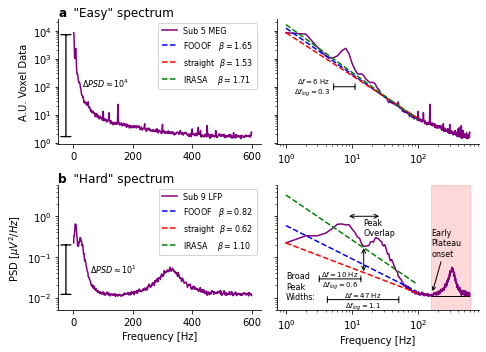

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(fig_width, 5), sharey="row")

ax[0, 0].text(s='    "Easy" spectrum', **panel_description,
              transform=ax[0, 0].transAxes)
ax[1, 0].text(s='    "Hard" spectrum', **panel_description,
              transform=ax[1, 0].transAxes)
# lin
ax[0, 0].semilogy(*PSD_plot_sub5, label="Sub 5 MEG")  # + ch5)
ax[1, 0].semilogy(*PSD_plot_sub9, label="Sub 9 LFP")  # + ch9)

# log
ax[0, 1].loglog(*PSD_plot_sub5, label="Sub 5 MEG")
ax[1, 1].loglog(*PSD_plot_sub9, label="Sub 9 LFP")

# Fooof fit
ax[0, 1].loglog(*fooof_plot_sub5,
                label=rf"FOOOF   $\beta=${exponent_sub5:.2f}")
ax[1, 1].loglog(*fooof_plot_sub9,
                label=rf"FOOOF   $\beta=${exponent_sub9:.2f}")

# Straight fit
ax[0, 1].loglog(*straight_plot_sub5,
                label=rf"straight  $\beta=${exponent_sub5_straight:.2f}")
ax[1, 1].loglog(*straight_plot_sub9,
                label=rf"straight  $\beta=${exponent_sub9_straight:.2f}")

# Low fit
ax[0, 1].loglog(*irasa_plot_sub5,
                label=rf"IRASA    $\beta=${exponent_irasa_sub5:.2f}")
ax[1, 1].loglog(*irasa_plot_sub9,
                label=rf"IRASA    $\beta=${exponent_irasa_sub9:.2f}")

for axes in ax.flatten():
    axes.spines["top"].set_visible(False)
    axes.spines["right"].set_visible(False)

# Legend
handles, labels = ax[0, 1].get_legend_handles_labels()
ax[0, 0].legend(handles, labels, fontsize=legend_fontsize, handlelength=1.9)
handles, labels = ax[1, 1].get_legend_handles_labels()
ax[1, 0].legend(handles, labels, fontsize=legend_fontsize, handlelength=1.9)

# Add Plateau rectangle
ylim_b = (5e-3, 6)
xlim_b = ax[1, 0].get_xlim()
noise_start = detect_plateau_onset(freq, PSD_sub9, 50)
rec_xy = (noise_start, ylim_b[0])
rec_width = freq[-1] - noise_start
rec_height = np.diff(ylim_b)[0]
rect_c = dict(xy=rec_xy, width=rec_width, height=rec_height,
              alpha=.15, color="r")
ax[1, 1].add_patch(plt.Rectangle(**rect_c))

# Add Plateau annotation
ax[1, 1].hlines(PSD_sub9[noise_start], noise_start, freq[-1], color="k",
                linewidth=1)
ax[1, 1].annotate(s="Early\nPlateau\nonset",
                  xy=(noise_start, PSD_sub9[noise_start]),
                  xytext=(noise_start, PSD_sub9[noise_start]*20),
                  arrowprops=dict(arrowstyle="->", shrinkB=5),
                  color="k", fontsize=8,
                  ha="left",
                  verticalalignment="center")

# Add Peak width annotation
height1 = 100
xmin1 = center_freq_sub5_1 - peak_width_sub5_1
xmax1 = center_freq_sub5_1 + peak_width_sub5_1
annotate_range(ax[0, 1], xmin1, xmax1, height1, annotate_pos="left")

# Add Peak width annotation
height1 = .029
height2 = 0.009
xmin1 = center_freq_sub9_1 - peak_width_sub9_1
xmax1 = center_freq_sub9_1 + peak_width_sub9_1
xmin2 = center_freq_sub9_2 - peak_width_sub9_2
xmax2 = center_freq_sub9_2 + peak_width_sub9_2
annotate_range(ax[1, 1], xmin1, xmax1, height1, annotate_pos=.93)
annotate_range(ax[1, 1], xmin2, xmax2, height2, annotate_pos=.93)

# Add indication of peak overlap as vertical arrow
overlap = 15
arr_height = 1
ax[1, 1].annotate(s="", xy=(overlap, PSD_sub9[overlap]),
                  xytext=(overlap, 10**ap_straight_fit_sub9[overlap]),
                  arrowprops=dict(arrowstyle="<->"))
ax[1, 1].annotate(s="", xy=(center_freq_sub9_1, arr_height),
                  xytext=(center_freq_sub9_2, arr_height),
                  arrowprops=dict(arrowstyle="<->"))
ax[1, 1].text(s="Broad\nPeak\nWidths:", x=1, y=(height1+height2)/2, ha="left",
              va="center", fontsize=8)
ax[1, 1].text(s="Peak\nOverlap", x=overlap, y=arr_height*.9, ha="left",
              va="top", fontsize=8)

# Annotate orders of magnitude
diff5 = PSD_sub5[0] / PSD_sub5.min()
ord_magn5 = int(np.round(np.log10(diff5)))
x_line = -25
ax[0, 0].annotate(s="",
                  xy=(x_line, PSD_sub5[0]),
                  xytext=(x_line, PSD_sub5.min()),
                  arrowprops=dict(arrowstyle="|-|,widthA=.5,widthB=.5",
                                  lw=1.3),
                  ha="center")
ax[0, 0].text(s=rf"$\Delta PSD\approx 10^{{{ord_magn5}}}$", x=30,
              y=np.sqrt(PSD_sub5[0]*PSD_sub5[-1]), va="center", fontsize=8)

diff9 = PSD_sub9[0] / PSD_sub9.min()
ord_magn9 = int(np.round(np.log10(diff9)))
x_line = -25
ax[1, 0].annotate(s="",
                  xy=(x_line, PSD_sub9[0]),
                  xytext=(x_line, PSD_sub9.min()),
                  arrowprops=dict(arrowstyle="|-|,widthA=.5,widthB=.5",
                                  lw=1.3), ha="center")
ax[1, 0].text(s=rf"$\Delta PSD\approx 10^{{{ord_magn9}}}$", x=55,
              y=np.sqrt(PSD_sub9[0]*PSD_sub9[-1]), va="center", fontsize=8)

xlim5 = ax[0, 0].get_xlim()
xlim9 = ax[1, 0].get_xlim()
ax[0, 0].set(xlabel=None, ylabel="A.U. Voxel Data", xlim=(-50, xlim5[1]))
ax[1, 0].set(xlabel=None, ylabel=None, xlim=(-50, xlim9[1]))
ax[1, 0].set(xlabel="Frequency [Hz]", ylabel=r"PSD [$\mu$$V^2/Hz$]")
ax[1, 1].set(xlabel="Frequency [Hz]", ylabel=None, ylim=ylim_b)
ax[0, 0].text(s="a", **panel_labels, transform=ax[0, 0].transAxes)
ax[1, 0].text(s="b", **panel_labels, transform=ax[1, 0].transAxes)

plt.tight_layout()
plt.savefig(fig_path + "Fig8.pdf", bbox_inches="tight")
plt.savefig(fig_path + "Fig8.png", dpi=1000, bbox_inches="tight")
plt.show()

# Appendix: Figure for presentation

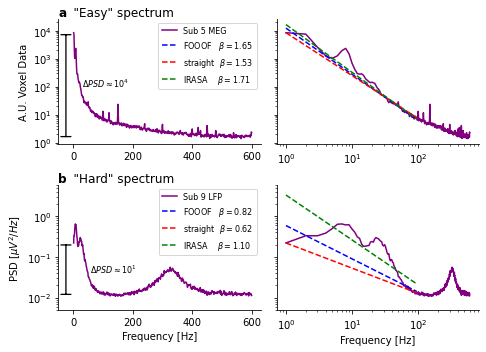

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(fig_width, 5), sharey="row")

ax[0, 0].text(s='    "Easy" spectrum', **panel_description,
              transform=ax[0, 0].transAxes)
ax[1, 0].text(s='    "Hard" spectrum', **panel_description,
              transform=ax[1, 0].transAxes)
# lin
ax[0, 0].semilogy(*PSD_plot_sub5, label="Sub 5 MEG")  # + ch5)
ax[1, 0].semilogy(*PSD_plot_sub9, label="Sub 9 LFP")  # + ch9)

# log
ax[0, 1].loglog(*PSD_plot_sub5, label="Sub 5 MEG")
ax[1, 1].loglog(*PSD_plot_sub9, label="Sub 9 LFP")

# Fooof fit
ax[0, 1].loglog(*fooof_plot_sub5,
                label=rf"FOOOF   $\beta=${exponent_sub5:.2f}")
ax[1, 1].loglog(*fooof_plot_sub9,
                label=rf"FOOOF   $\beta=${exponent_sub9:.2f}")

# Straight fit
ax[0, 1].loglog(*straight_plot_sub5,
                label=rf"straight  $\beta=${exponent_sub5_straight:.2f}")
ax[1, 1].loglog(*straight_plot_sub9,
                label=rf"straight  $\beta=${exponent_sub9_straight:.2f}")

# Low fit
ax[0, 1].loglog(*irasa_plot_sub5,
                label=rf"IRASA    $\beta=${exponent_irasa_sub5:.2f}")
ax[1, 1].loglog(*irasa_plot_sub9,
                label=rf"IRASA    $\beta=${exponent_irasa_sub9:.2f}")

for axes in ax.flatten():
    axes.spines["top"].set_visible(False)
    axes.spines["right"].set_visible(False)

# Legend
handles, labels = ax[0, 1].get_legend_handles_labels()
ax[0, 0].legend(handles, labels, fontsize=legend_fontsize, handlelength=1.9)
handles, labels = ax[1, 1].get_legend_handles_labels()
ax[1, 0].legend(handles, labels, fontsize=legend_fontsize, handlelength=1.9)

############################################
# ## Challenge 1:

# # Add Plateau rectangle
# ylim_b = (5e-3, 6)
# xlim_b = ax[1, 0].get_xlim()
# noise_start = detect_plateau_onset(freq, PSD_sub9, 50)
# rec_xy = (noise_start, ylim_b[0])
# rec_width = freq[-1] - noise_start
# rec_height = np.diff(ylim_b)[0]
# rect_c = dict(xy=rec_xy, width=rec_width, height=rec_height,
#               alpha=.15, color="r")
# ax[1, 1].add_patch(plt.Rectangle(**rect_c))

# # Add Plateau annotation
# ax[1, 1].hlines(PSD_sub9[noise_start], noise_start, freq[-1], color="k",
#                 linewidth=1)
# ax[1, 1].annotate(s="Early\nPlateau\nonset",
#                   xy=(noise_start, PSD_sub9[noise_start]),
#                   xytext=(noise_start, PSD_sub9[noise_start]*20),
#                   arrowprops=dict(arrowstyle="->", shrinkB=5),
#                   color="k", fontsize=8,
#                   ha="left",
#                   verticalalignment="center")
############################################

############################################
# # Challenge 2:

# # Add indication of peak overlap as vertical arrow
# overlap = 15
# arr_height = 1
# ax[1, 1].annotate(s="", xy=(overlap, PSD_sub9[overlap]),
#                   xytext=(overlap, 10**ap_straight_fit_sub9[overlap]),
#                   arrowprops=dict(arrowstyle="<->"))
# ax[1, 1].annotate(s="", xy=(center_freq_sub9_1, arr_height),
#                   xytext=(center_freq_sub9_2, arr_height),
#                   arrowprops=dict(arrowstyle="<->"))
# ax[1, 1].text(s="Peak\nOverlap", x=overlap, y=arr_height*.9, ha="left",
#               va="top", fontsize=8)
############################################

############################################
# # Challenge 3:
# ax[1, 1].text(s="Broad\nPeak\nWidths:", x=1, y=(height1+height2)/2, ha="left",
#               va="center", fontsize=8)
# # Add Peak width annotation
# height1 = 100
# xmin1 = center_freq_sub5_1 - peak_width_sub5_1
# xmax1 = center_freq_sub5_1 + peak_width_sub5_1
# annotate_range(ax[0, 1], xmin1, xmax1, height1, annotate_pos="left")

# # Add Peak width annotation
# height1 = .029
# height2 = 0.009
# xmin1 = center_freq_sub9_1 - peak_width_sub9_1
# xmax1 = center_freq_sub9_1 + peak_width_sub9_1
# xmin2 = center_freq_sub9_2 - peak_width_sub9_2
# xmax2 = center_freq_sub9_2 + peak_width_sub9_2
# annotate_range(ax[1, 1], xmin1, xmax1, height1, annotate_pos=.93)
# annotate_range(ax[1, 1], xmin2, xmax2, height2, annotate_pos=.93)
############################################

# Annotate orders of magnitude
diff5 = PSD_sub5[0] / PSD_sub5.min()
ord_magn5 = int(np.round(np.log10(diff5)))
x_line = -25
ax[0, 0].annotate(s="",
                  xy=(x_line, PSD_sub5[0]),
                  xytext=(x_line, PSD_sub5.min()),
                  arrowprops=dict(arrowstyle="|-|,widthA=.5,widthB=.5",
                                  lw=1.3),
                  ha="center")
ax[0, 0].text(s=rf"$\Delta PSD\approx 10^{{{ord_magn5}}}$", x=30,
              y=np.sqrt(PSD_sub5[0]*PSD_sub5[-1]), va="center", fontsize=8)

diff9 = PSD_sub9[0] / PSD_sub9.min()
ord_magn9 = int(np.round(np.log10(diff9)))
x_line = -25
ax[1, 0].annotate(s="",
                  xy=(x_line, PSD_sub9[0]),
                  xytext=(x_line, PSD_sub9.min()),
                  arrowprops=dict(arrowstyle="|-|,widthA=.5,widthB=.5",
                                  lw=1.3), ha="center")
ax[1, 0].text(s=rf"$\Delta PSD\approx 10^{{{ord_magn9}}}$", x=55,
              y=np.sqrt(PSD_sub9[0]*PSD_sub9[-1]), va="center", fontsize=8)

xlim5 = ax[0, 0].get_xlim()
xlim9 = ax[1, 0].get_xlim()
ax[0, 0].set(xlabel=None, ylabel="A.U. Voxel Data", xlim=(-50, xlim5[1]))
ax[1, 0].set(xlabel=None, ylabel=None, xlim=(-50, xlim9[1]))
ax[1, 0].set(xlabel="Frequency [Hz]", ylabel=r"PSD [$\mu$$V^2/Hz$]")
ax[1, 1].set(xlabel="Frequency [Hz]", ylabel=None, ylim=ylim_b)
ax[0, 0].text(s="a", **panel_labels, transform=ax[0, 0].transAxes)
ax[1, 0].text(s="b", **panel_labels, transform=ax[1, 0].transAxes)

plt.tight_layout()
plt.savefig(fig_path + "Fig8_Ch0.pdf", bbox_inches="tight")
plt.savefig(fig_path + "Fig8_Ch0.png", dpi=1000, bbox_inches="tight")
plt.show()

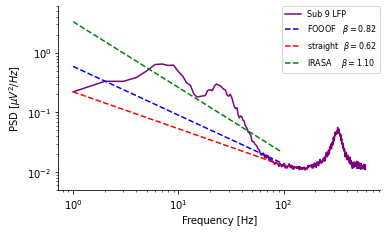

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width*4/5, 5*2/3), sharey="row")

ax.loglog(*PSD_plot_sub9, label="Sub 9 LFP")

# Fooof fit
ax.loglog(*fooof_plot_sub9,
                label=rf"FOOOF   $\beta=${exponent_sub9:.2f}")

# Straight fit
ax.loglog(*straight_plot_sub9,
                label=rf"straight  $\beta=${exponent_sub9_straight:.2f}")

# Low fit
ax.loglog(*irasa_plot_sub9,
                label=rf"IRASA    $\beta=${exponent_irasa_sub9:.2f}")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=legend_fontsize, handlelength=1.9, ncol=1,
          borderaxespad=0, loc="upper right")

############################################
# ## Challenge 1:

# # Add Plateau rectangle
# ylim_b = (5e-3, 6)
# xlim_b = ax[1, 0].get_xlim()
# noise_start = detect_plateau_onset(freq, PSD_sub9, 50)
# rec_xy = (noise_start, ylim_b[0])
# rec_width = freq[-1] - noise_start
# rec_height = np.diff(ylim_b)[0]
# rect_c = dict(xy=rec_xy, width=rec_width, height=rec_height,
#               alpha=.15, color="r")
# ax[1, 1].add_patch(plt.Rectangle(**rect_c))

# # Add Plateau annotation
# ax[1, 1].hlines(PSD_sub9[noise_start], noise_start, freq[-1], color="k",
#                 linewidth=1)
# ax[1, 1].annotate(s="Early\nPlateau\nonset",
#                   xy=(noise_start, PSD_sub9[noise_start]),
#                   xytext=(noise_start, PSD_sub9[noise_start]*20),
#                   arrowprops=dict(arrowstyle="->", shrinkB=5),
#                   color="k", fontsize=8,
#                   ha="left",
#                   verticalalignment="center")
############################################

############################################
# # Challenge 2:

# # Add indication of peak overlap as vertical arrow
# overlap = 15
# arr_height = 1
# ax[1, 1].annotate(s="", xy=(overlap, PSD_sub9[overlap]),
#                   xytext=(overlap, 10**ap_straight_fit_sub9[overlap]),
#                   arrowprops=dict(arrowstyle="<->"))
# ax[1, 1].annotate(s="", xy=(center_freq_sub9_1, arr_height),
#                   xytext=(center_freq_sub9_2, arr_height),
#                   arrowprops=dict(arrowstyle="<->"))
# ax[1, 1].text(s="Peak\nOverlap", x=overlap, y=arr_height*.9, ha="left",
#               va="top", fontsize=8)
############################################

############################################
# # Challenge 3:
# ax[1, 1].text(s="Broad\nPeak\nWidths:", x=1, y=(height1+height2)/2, ha="left",
#               va="center", fontsize=8)
# # Add Peak width annotation
# height1 = 100
# xmin1 = center_freq_sub5_1 - peak_width_sub5_1
# xmax1 = center_freq_sub5_1 + peak_width_sub5_1
# annotate_range(ax[0, 1], xmin1, xmax1, height1, annotate_pos="left")

# # Add Peak width annotation
# height1 = .029
# height2 = 0.009
# xmin1 = center_freq_sub9_1 - peak_width_sub9_1
# xmax1 = center_freq_sub9_1 + peak_width_sub9_1
# xmin2 = center_freq_sub9_2 - peak_width_sub9_2
# xmax2 = center_freq_sub9_2 + peak_width_sub9_2
# annotate_range(ax[1, 1], xmin1, xmax1, height1, annotate_pos=.93)
# annotate_range(ax[1, 1], xmin2, xmax2, height2, annotate_pos=.93)
############################################

ax.set(xlabel="Frequency [Hz]", ylabel=r"PSD [$\mu$$V^2/Hz$]", ylim=ylim_b)

plt.tight_layout()
plt.savefig(fig_path + "Fig8_Ch0.pdf", bbox_inches="tight")
plt.show()

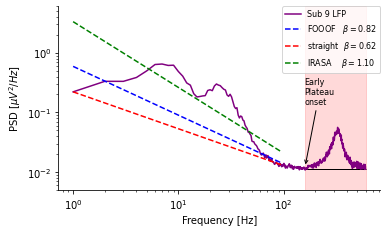

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width*4/5, 5*2/3), sharey="row")

ax.loglog(*PSD_plot_sub9, label="Sub 9 LFP")

# Fooof fit
ax.loglog(*fooof_plot_sub9,
                label=rf"FOOOF   $\beta=${exponent_sub9:.2f}")

# Straight fit
ax.loglog(*straight_plot_sub9,
                label=rf"straight  $\beta=${exponent_sub9_straight:.2f}")

# Low fit
ax.loglog(*irasa_plot_sub9,
                label=rf"IRASA    $\beta=${exponent_irasa_sub9:.2f}")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=legend_fontsize, handlelength=1.9, ncol=1,
          borderaxespad=0, loc="upper right")

############################################
## Challenge 1:

# Add Plateau rectangle
ylim_b = (5e-3, 6)
xlim_b = ax.get_xlim()
noise_start = detect_plateau_onset(freq, PSD_sub9, 50)
rec_xy = (noise_start, ylim_b[0])
rec_width = freq[-1] - noise_start
rec_height = np.diff(ylim_b)[0]
rect_c = dict(xy=rec_xy, width=rec_width, height=rec_height,
              alpha=.15, color="r")
ax.add_patch(plt.Rectangle(**rect_c))

# Add Plateau annotation
ax.hlines(PSD_sub9[noise_start], noise_start, freq[-1], color="k",
                linewidth=1)
ax.annotate(s="Early\nPlateau\nonset",
                  xy=(noise_start, PSD_sub9[noise_start]),
                  xytext=(noise_start, PSD_sub9[noise_start]*20),
                  arrowprops=dict(arrowstyle="->", shrinkB=5),
                  color="k", fontsize=8,
                  ha="left",
                  verticalalignment="center")
############################################

############################################
# # Challenge 2:

# # Add indication of peak overlap as vertical arrow
# overlap = 15
# arr_height = 1
# ax[1, 1].annotate(s="", xy=(overlap, PSD_sub9[overlap]),
#                   xytext=(overlap, 10**ap_straight_fit_sub9[overlap]),
#                   arrowprops=dict(arrowstyle="<->"))
# ax[1, 1].annotate(s="", xy=(center_freq_sub9_1, arr_height),
#                   xytext=(center_freq_sub9_2, arr_height),
#                   arrowprops=dict(arrowstyle="<->"))
# ax[1, 1].text(s="Peak\nOverlap", x=overlap, y=arr_height*.9, ha="left",
#               va="top", fontsize=8)
############################################

############################################
# # Challenge 3:
# ax[1, 1].text(s="Broad\nPeak\nWidths:", x=1, y=(height1+height2)/2, ha="left",
#               va="center", fontsize=8)
# # Add Peak width annotation
# height1 = 100
# xmin1 = center_freq_sub5_1 - peak_width_sub5_1
# xmax1 = center_freq_sub5_1 + peak_width_sub5_1
# annotate_range(ax[0, 1], xmin1, xmax1, height1, annotate_pos="left")

# # Add Peak width annotation
# height1 = .029
# height2 = 0.009
# xmin1 = center_freq_sub9_1 - peak_width_sub9_1
# xmax1 = center_freq_sub9_1 + peak_width_sub9_1
# xmin2 = center_freq_sub9_2 - peak_width_sub9_2
# xmax2 = center_freq_sub9_2 + peak_width_sub9_2
# annotate_range(ax[1, 1], xmin1, xmax1, height1, annotate_pos=.93)
# annotate_range(ax[1, 1], xmin2, xmax2, height2, annotate_pos=.93)
############################################

ax.set(xlabel="Frequency [Hz]", ylabel=r"PSD [$\mu$$V^2/Hz$]", ylim=ylim_b)

plt.tight_layout()
plt.savefig(fig_path + "Fig8_Ch1.pdf", bbox_inches="tight")
plt.show()

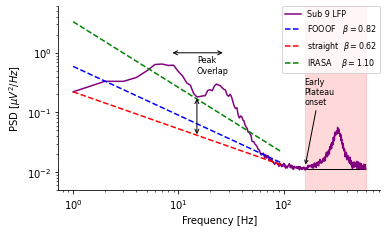

In [39]:

fig, ax = plt.subplots(1, 1, figsize=(fig_width*4/5, 5*2/3), sharey="row")

ax.loglog(*PSD_plot_sub9, label="Sub 9 LFP")

# Fooof fit
ax.loglog(*fooof_plot_sub9,
                label=rf"FOOOF   $\beta=${exponent_sub9:.2f}")

# Straight fit
ax.loglog(*straight_plot_sub9,
                label=rf"straight  $\beta=${exponent_sub9_straight:.2f}")

# Low fit
ax.loglog(*irasa_plot_sub9,
                label=rf"IRASA    $\beta=${exponent_irasa_sub9:.2f}")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=legend_fontsize, handlelength=1.9, ncol=1,
          borderaxespad=0, loc="upper right")

############################################
## Challenge 1:

# Add Plateau rectangle
ylim_b = (5e-3, 6)
xlim_b = ax.get_xlim()
noise_start = detect_plateau_onset(freq, PSD_sub9, 50)
rec_xy = (noise_start, ylim_b[0])
rec_width = freq[-1] - noise_start
rec_height = np.diff(ylim_b)[0]
rect_c = dict(xy=rec_xy, width=rec_width, height=rec_height,
              alpha=.15, color="r")
ax.add_patch(plt.Rectangle(**rect_c))

# Add Plateau annotation
ax.hlines(PSD_sub9[noise_start], noise_start, freq[-1], color="k",
                linewidth=1)
ax.annotate(s="Early\nPlateau\nonset",
                  xy=(noise_start, PSD_sub9[noise_start]),
                  xytext=(noise_start, PSD_sub9[noise_start]*20),
                  arrowprops=dict(arrowstyle="->", shrinkB=5),
                  color="k", fontsize=8,
                  ha="left",
                  verticalalignment="center")
############################################

############################################
# Challenge 2:

# Add indication of peak overlap as vertical arrow
overlap = 15
arr_height = 1
ax.annotate(s="", xy=(overlap, PSD_sub9[overlap]),
                  xytext=(overlap, 10**ap_straight_fit_sub9[overlap]),
                  arrowprops=dict(arrowstyle="<->"))
ax.annotate(s="", xy=(center_freq_sub9_1, arr_height),
                  xytext=(center_freq_sub9_2, arr_height),
                  arrowprops=dict(arrowstyle="<->"))
ax.text(s="Peak\nOverlap", x=overlap, y=arr_height*.9, ha="left",
              va="top", fontsize=8)
############################################

############################################
# # Challenge 3:
# ax[1, 1].text(s="Broad\nPeak\nWidths:", x=1, y=(height1+height2)/2, ha="left",
#               va="center", fontsize=8)
# # Add Peak width annotation
# height1 = 100
# xmin1 = center_freq_sub5_1 - peak_width_sub5_1
# xmax1 = center_freq_sub5_1 + peak_width_sub5_1
# annotate_range(ax[0, 1], xmin1, xmax1, height1, annotate_pos="left")

# # Add Peak width annotation
# height1 = .029
# height2 = 0.009
# xmin1 = center_freq_sub9_1 - peak_width_sub9_1
# xmax1 = center_freq_sub9_1 + peak_width_sub9_1
# xmin2 = center_freq_sub9_2 - peak_width_sub9_2
# xmax2 = center_freq_sub9_2 + peak_width_sub9_2
# annotate_range(ax[1, 1], xmin1, xmax1, height1, annotate_pos=.93)
# annotate_range(ax[1, 1], xmin2, xmax2, height2, annotate_pos=.93)
############################################

ax.set(xlabel="Frequency [Hz]", ylabel=r"PSD [$\mu$$V^2/Hz$]", ylim=ylim_b)

plt.tight_layout()
plt.savefig(fig_path + "Fig8_Ch2.pdf", bbox_inches="tight")
plt.show()

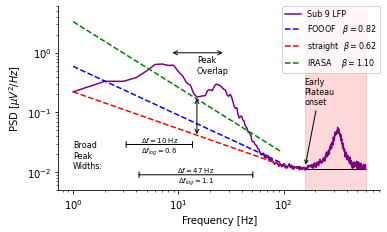

In [40]:

fig, ax = plt.subplots(1, 1, figsize=(fig_width*4/5, 5*2/3), sharey="row")

ax.loglog(*PSD_plot_sub9, label="Sub 9 LFP")

# Fooof fit
ax.loglog(*fooof_plot_sub9,
                label=rf"FOOOF   $\beta=${exponent_sub9:.2f}")

# Straight fit
ax.loglog(*straight_plot_sub9,
                label=rf"straight  $\beta=${exponent_sub9_straight:.2f}")

# Low fit
ax.loglog(*irasa_plot_sub9,
                label=rf"IRASA    $\beta=${exponent_irasa_sub9:.2f}")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=legend_fontsize, handlelength=1.9, ncol=1,
          borderaxespad=0, loc="upper right")

############################################
## Challenge 1:

# Add Plateau rectangle
ylim_b = (5e-3, 6)
xlim_b = ax.get_xlim()
noise_start = detect_plateau_onset(freq, PSD_sub9, 50)
rec_xy = (noise_start, ylim_b[0])
rec_width = freq[-1] - noise_start
rec_height = np.diff(ylim_b)[0]
rect_c = dict(xy=rec_xy, width=rec_width, height=rec_height,
              alpha=.15, color="r")
ax.add_patch(plt.Rectangle(**rect_c))

# Add Plateau annotation
ax.hlines(PSD_sub9[noise_start], noise_start, freq[-1], color="k",
                linewidth=1)
ax.annotate(s="Early\nPlateau\nonset",
                  xy=(noise_start, PSD_sub9[noise_start]),
                  xytext=(noise_start, PSD_sub9[noise_start]*20),
                  arrowprops=dict(arrowstyle="->", shrinkB=5),
                  color="k", fontsize=8,
                  ha="left",
                  verticalalignment="center")
############################################

############################################
# Challenge 2:

# Add indication of peak overlap as vertical arrow
overlap = 15
arr_height = 1
ax.annotate(s="", xy=(overlap, PSD_sub9[overlap]),
                  xytext=(overlap, 10**ap_straight_fit_sub9[overlap]),
                  arrowprops=dict(arrowstyle="<->"))
ax.annotate(s="", xy=(center_freq_sub9_1, arr_height),
                  xytext=(center_freq_sub9_2, arr_height),
                  arrowprops=dict(arrowstyle="<->"))
ax.text(s="Peak\nOverlap", x=overlap, y=arr_height*.9, ha="left",
              va="top", fontsize=8)
############################################

############################################
# Challenge 3:
ax.text(s="Broad\nPeak\nWidths:", x=1, y=(height1+height2)/2, ha="left",
              va="center", fontsize=8)
# Add Peak width annotation
height1 = 100
xmin1 = center_freq_sub5_1 - peak_width_sub5_1
xmax1 = center_freq_sub5_1 + peak_width_sub5_1
# annotate_range(ax[0, 1], xmin1, xmax1, height1, annotate_pos="left")

# Add Peak width annotation
height1 = .029
height2 = 0.009
xmin1 = center_freq_sub9_1 - peak_width_sub9_1
xmax1 = center_freq_sub9_1 + peak_width_sub9_1
xmin2 = center_freq_sub9_2 - peak_width_sub9_2
xmax2 = center_freq_sub9_2 + peak_width_sub9_2
annotate_range(ax, xmin1, xmax1, height1, annotate_pos=.93)
annotate_range(ax, xmin2, xmax2, height2, annotate_pos=.93)
############################################

ax.set(xlabel="Frequency [Hz]", ylabel=r"PSD [$\mu$$V^2/Hz$]", ylim=ylim_b)

plt.tight_layout()
plt.savefig(fig_path + "Fig8_Ch3.pdf", bbox_inches="tight")
plt.show()

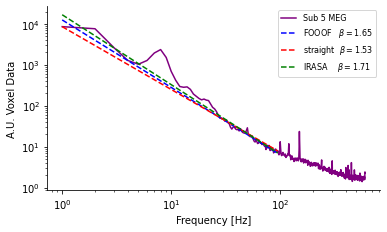

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width*4/5, 5*2/3), sharey="row")

# log
ax.loglog(*PSD_plot_sub5, label="Sub 5 MEG")

# Fooof fit
ax.loglog(*fooof_plot_sub5,
                label=rf"FOOOF   $\beta=${exponent_sub5:.2f}")

# Straight fit
ax.loglog(*straight_plot_sub5,
                label=rf"straight  $\beta=${exponent_sub5_straight:.2f}")

# Low fit
ax.loglog(*irasa_plot_sub5,
                label=rf"IRASA    $\beta=${exponent_irasa_sub5:.2f}")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=legend_fontsize, handlelength=1.9)

############################################
# ## Challenge 1:

# # Add Plateau rectangle
# ylim_b = (5e-3, 6)
# xlim_b = ax[1, 0].get_xlim()
# noise_start = detect_plateau_onset(freq, PSD_sub9, 50)
# rec_xy = (noise_start, ylim_b[0])
# rec_width = freq[-1] - noise_start
# rec_height = np.diff(ylim_b)[0]
# rect_c = dict(xy=rec_xy, width=rec_width, height=rec_height,
#               alpha=.15, color="r")
# ax[1, 1].add_patch(plt.Rectangle(**rect_c))

# # Add Plateau annotation
# ax[1, 1].hlines(PSD_sub9[noise_start], noise_start, freq[-1], color="k",
#                 linewidth=1)
# ax[1, 1].annotate(s="Early\nPlateau\nonset",
#                   xy=(noise_start, PSD_sub9[noise_start]),
#                   xytext=(noise_start, PSD_sub9[noise_start]*20),
#                   arrowprops=dict(arrowstyle="->", shrinkB=5),
#                   color="k", fontsize=8,
#                   ha="left",
#                   verticalalignment="center")
############################################

############################################
# # Challenge 2:

# # Add indication of peak overlap as vertical arrow
# overlap = 15
# arr_height = 1
# ax[1, 1].annotate(s="", xy=(overlap, PSD_sub9[overlap]),
#                   xytext=(overlap, 10**ap_straight_fit_sub9[overlap]),
#                   arrowprops=dict(arrowstyle="<->"))
# ax[1, 1].annotate(s="", xy=(center_freq_sub9_1, arr_height),
#                   xytext=(center_freq_sub9_2, arr_height),
#                   arrowprops=dict(arrowstyle="<->"))
# ax[1, 1].text(s="Peak\nOverlap", x=overlap, y=arr_height*.9, ha="left",
#               va="top", fontsize=8)
############################################

############################################
# # Challenge 3:
# ax[1, 1].text(s="Broad\nPeak\nWidths:", x=1, y=(height1+height2)/2, ha="left",
#               va="center", fontsize=8)
# # Add Peak width annotation
# height1 = 100
# xmin1 = center_freq_sub5_1 - peak_width_sub5_1
# xmax1 = center_freq_sub5_1 + peak_width_sub5_1
# annotate_range(ax[0, 1], xmin1, xmax1, height1, annotate_pos="left")

# # Add Peak width annotation
# height1 = .029
# height2 = 0.009
# xmin1 = center_freq_sub9_1 - peak_width_sub9_1
# xmax1 = center_freq_sub9_1 + peak_width_sub9_1
# xmin2 = center_freq_sub9_2 - peak_width_sub9_2
# xmax2 = center_freq_sub9_2 + peak_width_sub9_2
# annotate_range(ax[1, 1], xmin1, xmax1, height1, annotate_pos=.93)
# annotate_range(ax[1, 1], xmin2, xmax2, height2, annotate_pos=.93)
############################################
ax.set(xlabel="Frequency [Hz]", ylabel="A.U. Voxel Data")

plt.tight_layout()
plt.savefig(fig_path + "Fig8_MEG.pdf", bbox_inches="tight")
plt.show()